<a href="https://colab.research.google.com/github/DrZubi/MIDS_DATASCI_207/blob/Priya/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emotions Decoded: The Power of CNNs in Facial Expression Recognition**

#### **Rationale**
Facial expression recognition is a critical aspect of human-computer interaction, enabling machines to understand and respond to human emotions.

This project has the **objective** to develop a robust and efficient **Convolutional Neural Network (CNN)** model to accurately classify **facial expressions** into seven distinct categories:
- Angry
- Disgust
- Fear
- Happy
- Sad
- Surprise
- Neutral

By leveraging the power of deep learning, the model will automatically learn and identify complex patterns in facial images, facilitating improved emotional intelligence in various applications such as social robots, virtual assistants, and mental health monitoring systems.

#### **Motivation**
The ability to accurately recognize human emotions through facial expressions has vast implications across multiple domains. Enhancing machine understanding of emotions can lead to more intuitive interactions between humans and machines, improve customer service experiences, enhance security systems, and contribute to psychological research. This project seeks to harness the capabilities of CNNs to push the boundaries of emotion recognition technology, ultimately fostering more empathetic and responsive AI systems.

#### **Data**
The dataset used in this project comprises 48x48 pixel grayscale images of faces, each depicting one of seven emotions. The images are pre-processed to ensure that the faces are centered and occupy a similar amount of space within each frame. This standardization aids the CNN in learning consistent features across different expressions. The goal is to categorize each face based on the emotion displayed in the facial expression into one of the predefined seven categories.

The dataset is sourced from Kaggle, specifically from the “Challenges in Representation Learning: Facial Expression Recognition Challenge” competition. It provides a comprehensive collection of labeled facial images, essential for training and evaluating the performance of the CNN model. The dataset can be accessed on Kaggole [[Source]](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

#### **Authors**
- Serah Almeyda
- Priya Iragavarapu
- Francesca Scipioni
- Sowjanya Yaddanapudi
- Omar Zu’bi

---
### **Step 1:** Import libraries

In [1]:
# Standard Imports
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import import_ipynb

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# keras_tuner
import keras_tuner as kt
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Custom user defined imports
# from camera_feed import live_feed

# Inline and set seeds
np.random.seed(0)
tf.random.set_seed(1234)

<ipython-input-1-8a89c6d3f0be>:27: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


---
### **Step 2:**  Loading and Understanding the Dataset

In this section, we will:  
- Load the dataset into a pandas DataFrame.  
- Understand the size and structure of the dataset.  
- Identify the unique emotion categories present in the dataset.

In [3]:
# from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

# current_dir = os.getcwd()
current_dir = '/content/drive/MyDrive/DATASCI207-FINAL_PROJECT/'

# Import dataset
file_path = os.path.join(current_dir, 'icml_face_data.csv')
df = pd.read_csv(file_path)

Mounted at /content/drive


In [4]:
# Display the shape of the dataset to understand its size (rows, columns)
print(f'Dataset size: {df.shape}')

# Display the unique emotion categories present in the dataset
unique_emotions = np.sort(df['emotion'].unique())
print(f'Unique emotions categories: {unique_emotions}')

# Display the first five rows of the DataFrame to get an overview of the data
print('\n')
df.head()

Dataset size: (35887, 3)
Unique emotions categories: [0 1 2 3 4 5 6]




,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


**Comment**  
The dataset consists of **35,887 images**, each corresponding to one of seven different facial expression categories. The numbers in parentheses represent the facial expressions’ unique labels:

**Emotion Categories:**  
1.	Angry (*0*)  
2.	Disgust (*1*)  
3.	Fear (*2*)  
4.	Happy (*3*)  
5.	Sad (*4*)  
6.	Surprise (*5*)  
7.	Neutral (*6*)

In [5]:
# Correct column names by converting to lowercase and removing spaces
df.columns = df.columns.str.lower().str.replace(' ', '')

# Function to convert pixel strings to numpy arrays
def string_to_array(string):
    """
    Convert a string of pixel values to a numpy array.

    Args:
    string (str): A string of pixel values separated by spaces.

    Returns:
    np.ndarray: A 48x48 numpy array of pixel values.
    """
    return np.array(string.split(), dtype='float32').reshape(48, 48)

# Apply the function to convert pixel strings to numpy arrays
df['image'] = df['pixels'].apply(string_to_array)

# Create a mapping of emotion labels to their corresponding emotion names
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Apply the mapping to create a new column with emotion names
df['emotion_label'] = df['emotion'].map(emotion_mapping)

---
### **Step 3:** Exploratory Data Analysis (EDA)

To gain a deeper understanding of the dataset and its characteristics, we will create four visualizations:

**1. Histogram of Emotion Label Distribution:**  
&nbsp; &nbsp; &nbsp; We will create a histogram to show the distribution of the emotion labels. This helps us to check if the classes are balanced or if there is any significant class imbalance. A balanced dataset is crucial for training a robust model.

**2. Sample Images per Emotion:**  
&nbsp; &nbsp; &nbsp; We will create a grid of sample images for each emotion category. This visual inspection allows us to see the quality and characteristics of the images corresponding to each emotion. It provides an intuitive understanding of what each emotion looks like in the dataset.

**3. Image Variability per Emotion:**  
&nbsp; &nbsp; &nbsp; We will plot the variability (standard deviation) of pixel values within each emotion category. This plot will give insights into how much variation there is in the images of each emotion. High variability within an emotion category might indicate diverse expressions or inconsistencies in image quality.

**4. PCA (Principal Component Analysis):**  
&nbsp; &nbsp; &nbsp; We will apply PCA on the pixel data to reduce its dimensionality and visualize the first two principal components. This can help us see if images of different emotions are separable in lower dimensions. PCA is a powerful tool for understanding the intrinsic structure of the data and can highlight any clustering or overlap between different emotion categories.

**1. Histogram of Emotion Label Distribution**

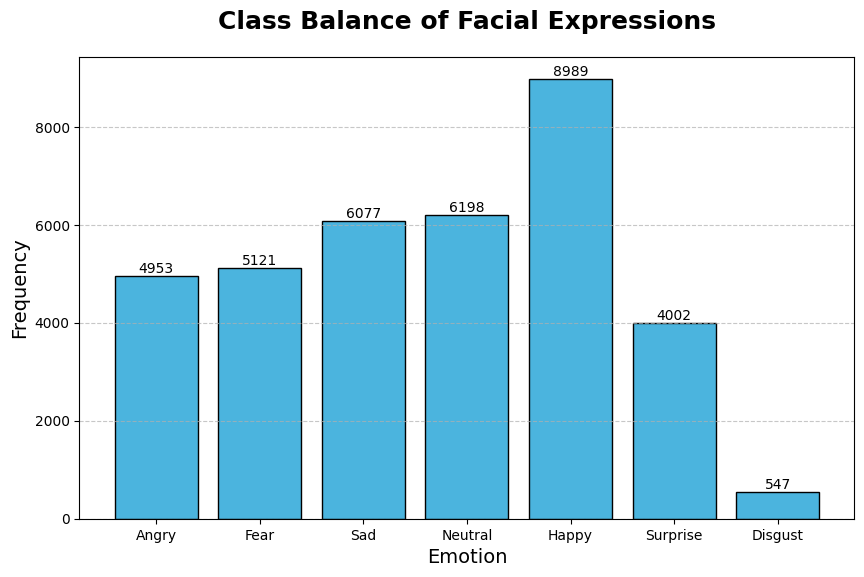

In [6]:
# Plot the histogram
plt.figure(figsize=(10, 6))

# Create histogram
counts, bins, patches = plt.hist(df['emotion_label'],
                                 bins=np.arange(8) - 0.5,
                                 edgecolor='black',
                                 align='mid',
                                 color='#4BB4DE',
                                 rwidth=0.8)

# Set labels and title
plt.xlabel('Emotion',
           fontsize=14
          )
plt.ylabel('Frequency',
           fontsize=14
          )
plt.title('Class Balance of Facial Expressions',
          fontsize=18,
          fontweight='bold',
          pad=20
         )

# Set x-ticks to show emotion labels
plt.xticks(range(7))

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of the bars
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2,
             height,
             int(count),
             ha='center',
             va='bottom')

# Display the plot
plt.show()

**Comment**  

There is a **severe class imbalance** between the different emotion classes in the dataset. The “Happy” class, with 8,989 instances, is significantly overrepresented compared to the other classes. In stark contrast, the “Disgust” class is particularly underrepresented, with only 547 instances. This means that the “Happy” class has approximately 16 times more samples than the “Disgust” class.

Implications of Class Imbalance:

1.	**Model Bias:**  
- When training a model on imbalanced data, the model is likely to become biased towards the majority class (“Happy”). This bias occurs because the model encounters the majority class more frequently, leading it to favor predictions for this class.
2.	**Poor Performance on Minority Classes:**  
- The underrepresented classes, such as “Disgust”, may not be learned effectively by the model. As a result, the model may have poor accuracy and higher error rates when predicting these classes, as it has fewer examples to learn from.
3.	**Misleading Accuracy:**
- Overall accuracy can be misleading in the presence of class imbalance. A high accuracy might simply reflect the model’s ability to predict the majority class correctly, while failing to perform well on the minority classes.
4.	**Impact on Real-world Applications:**
- In real-world applications, such as emotion recognition systems, it is crucial to accurately detect all emotion classes, especially those that are less frequent. Misclassifying or failing to detect certain emotions can lead to significant issues in applications like mental health monitoring, human-computer interaction, and customer service.

**2. Sample Images per Emotion**

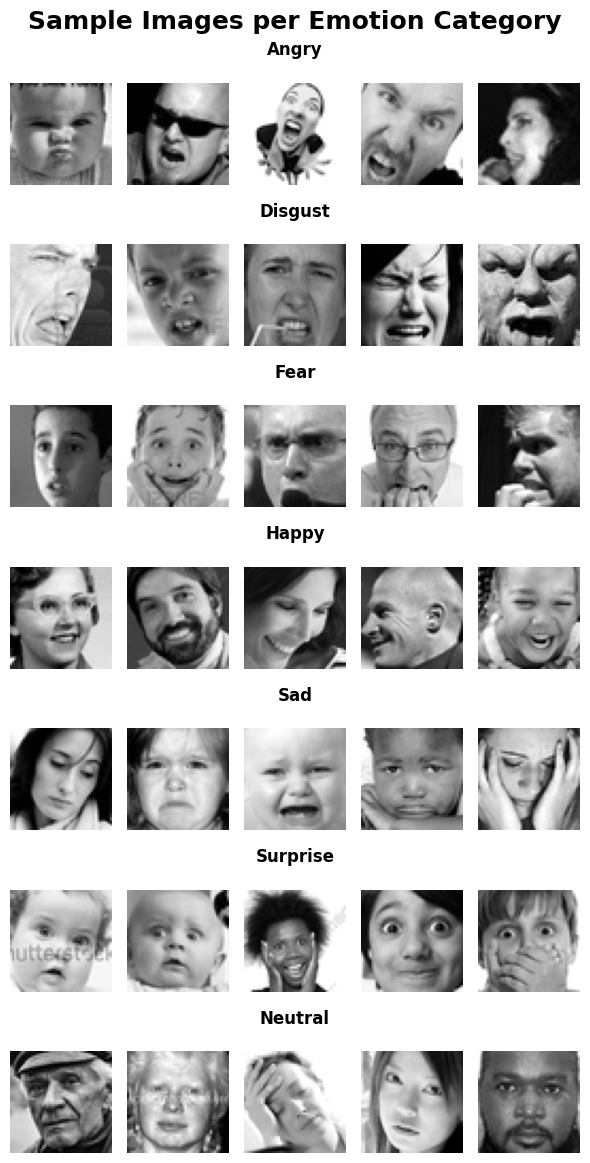

In [7]:
# Get unique emotion classes
emotion_classes = np.sort(df['emotion'].unique())

# Define the number of images to display per emotion class
num_images_per_class = 5

# Create a figure with a grid of subplots
fig, axes = plt.subplots(len(emotion_classes),
                         num_images_per_class,
                         figsize=(6, 12))

# Add a main title to the figure
fig.suptitle('Sample Images per Emotion Category',
             fontsize=18,
              fontweight='bold'
            )

# Specify seed for consistent results
np.random.seed(0)

# Iterate through each emotion class and plot images
for i, emotion_class in enumerate(emotion_classes):

    # Select 5 random images from the current emotion class
    images = df[df['emotion'] == emotion_class].sample(num_images_per_class, random_state=0)['image'].values

    # Plot each image in the grid
    for j in range(num_images_per_class):
        axes[i, j].imshow(images[j], cmap='gray')
        axes[i, j].axis('off')

    # Add emotion label in the middle of each row
    middle_index = num_images_per_class // 2
    axes[i, middle_index].set_title(f'{emotion_mapping[emotion_class]}', fontsize=12, pad=20, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

**Comment**  
The dataset contains 48x48 pixel grayscale images of faces. The faces have been automatically registered to ensure they are centered and occupy roughly the same amount of space in each image. This standardization helps in maintaining consistency across the dataset, which is crucial for training robust machine learning models.

However, upon closer inspection, it is evident that some images not only contain the faces but also include the person’s hands. These additional elements, such as hair, ears, and neck, are also captured within the 48x48 pixel frame. The positioning and presence of these features can potentially enhance the perception of the displayed emotion. For instance, a tilted head or visible neck tension might amplify the expression of emotions like sadness or anger.

Implications for Classifier Performance:

1.	**Influence of Additional Features:**
- The inclusion of head elements beyond the facial region might introduce additional features that the classifier can learn from. These features could either aid or hinder the classifier’s ability to accurately detect emotions, depending on their relevance and consistency.
2.	**Enhanced Emotion Cues:**
- Head positions and associated features can provide supplementary cues for emotion detection. For example, a bowed head might emphasize sadness, while an upright and tense posture might underscore anger. The classifier might learn to associate these cues with specific emotions, potentially improving its accuracy.
3.	**Inconsistent Features:**
- On the flip side, the variability in head positions and additional features might introduce noise and inconsistencies, making it harder for the classifier to focus solely on the facial expressions. This variability could potentially degrade the model’s performance if it learns to rely on less consistent features.
4.	**Impact on Generalization:**
- The classifier’s reliance on head positions and additional features might impact its generalization to new data. If new images differ in how much of the head is included, the classifier’s performance could vary. Ensuring the model learns to prioritize facial expressions over less reliable head features is critical.

**3. Image Variability per Emotion**

In [8]:
def prepare_image(df):
    # Convert pixels string to numpy array and normalize pixel values
    df1 = pd.DataFrame()
    df1['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32') / 255.0)

    # Reshape data into the required format
    image = np.array(df1['pixels'].tolist()).reshape(-1, 48, 48, 1)

    return image

image = prepare_image(df)

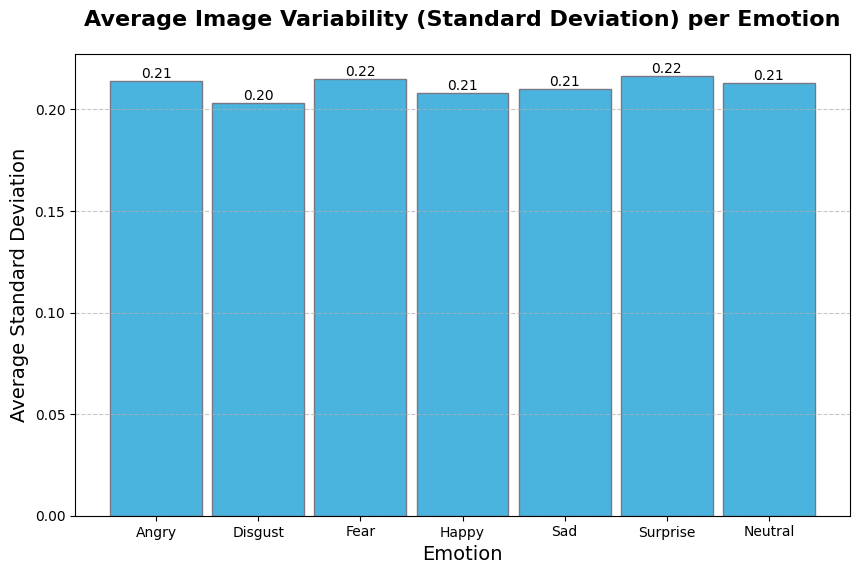

In [9]:
def plot_image_variability(df, image):
    # Calculate the standard deviation of each image
    pixel_std = np.std(image, axis=(1, 2, 3))

    # Create a DataFrame for standard deviations
    df_std = pd.DataFrame({'emotion': df['emotion'], 'pixel_std': pixel_std})

    # Calculate the average standard deviation per emotion
    std_per_emotion = df_std.groupby('emotion')['pixel_std'].mean()

    # Plot the average standard deviation per emotion
    plt.figure(figsize=(10, 6))

    # Create bar plot
    counts = std_per_emotion.values
    bins = np.arange(len(std_per_emotion))
    patches = plt.bar(bins, counts, edgecolor='#787785', color='#4BB4DE', width=0.9)

    # Set labels and title
    plt.xlabel('Emotion', fontsize=14)
    plt.ylabel('Average Standard Deviation', fontsize=14)
    plt.title('Average Image Variability (Standard Deviation) per Emotion', fontsize=16, fontweight='bold', pad=20)

    # Set x-ticks to show emotion labels
    plt.xticks(bins, [emotion_mapping[e] for e in std_per_emotion.index])

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add data labels on top of the bars
    for count, patch in zip(counts, patches):
        height = patch.get_height()
        plt.text(patch.get_x() + patch.get_width() / 2,
                 height,
                 f'{count:.2f}',
                 ha='center',
                 va='bottom')

    # Display the plot
    plt.show()

plot_image_variability(df, image)

**Comment**  
The seven emotions (classes) exhibit a uniform average standard deviation in pixel values. This indicates that the variability within each emotion category is consistent across the different emotions. In other words, the dispersion of pixel intensities within each emotion class is similar, suggesting that the images for each emotion have comparable levels of detail and variability.

**4. PCA (Principal Component Analysis)**

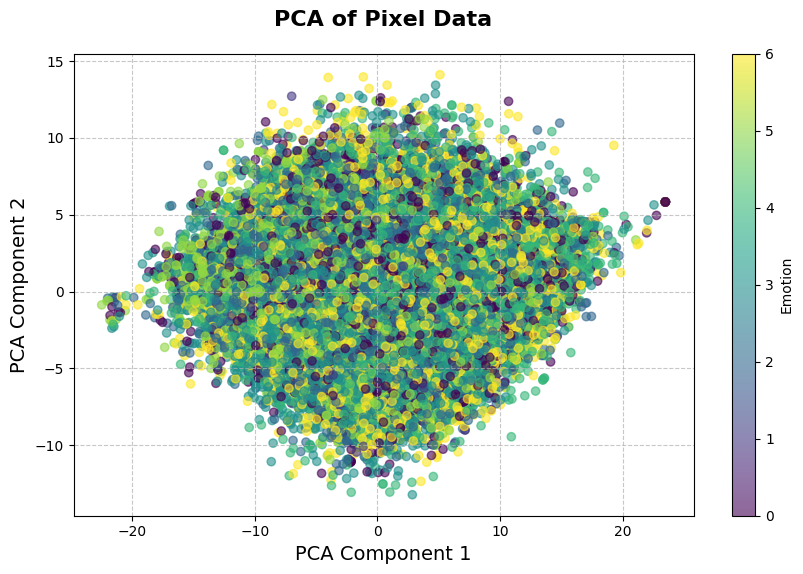

In [10]:
def plot_pca(df, image):
    # Flatten the arrays for PCA
    flat_pixels = image.reshape(image.shape[0], -1)

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(flat_pixels)

    # Create a DataFrame for PCA results
    df_pca = pd.DataFrame({
        'emotion': df['emotion'],
        'pca_one': pca_result[:, 0],
        'pca_two': pca_result[:, 1]
    })

    # Plot PCA results
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df_pca['pca_one'], df_pca['pca_two'], c=df_pca['emotion'], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Emotion')
    plt.title('PCA of Pixel Data', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('PCA Component 1', fontsize=14)
    plt.ylabel('PCA Component 2', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_pca(df, image)

**Comment**  

The PCA plot demonstrates that the pixel data for different facial expressions exhibit considerable overlap in the first two principal components. This indicates that further analysis, possibly using additional features or more sophisticated models, is required to effectively separate and classify the different emotions.

In detail:

1.	**Dense Cluster:**
- The plot shows a dense central cluster with data points spread outwards, indicating that the majority of the variance is captured within this central region.
- This clustering suggests that the pixel data for different emotions share significant similarities, making it challenging to separate them distinctly based on the first two principal components.
2.	**Overlap of Emotions:**
- The color bar represents different emotions, with each color corresponding to a unique emotion label.
- The colors are intermixed throughout the plot, indicating that the emotions are not easily separable in this reduced two-dimensional space.
- This overlap suggests that the pixel intensity patterns for different emotions are not distinct enough to be clearly separated by PCA alone.
3.	**Variation Spread:**
- The spread of points along both PCA components shows the extent of variation in the data.
- Although there is some spread, the overall circular shape implies that the principal components do not capture clear linear separations between the emotion classes.

---
### **Step 4:** Data preprocessing

#### **Class imbalance**

We will address the issue of class imbalance. The presence of imbalanced data can significantly hinder the detection of rare classes (emotions) because most classification methods implicitly assume that all classes occur with similar frequency. These methods are typically designed to maximize overall classification accuracy, which can lead to poor performance on underrepresented classes.

To correct for class imbalance, we will use oversampling techniques to increase the number of instances in the smallest class. This process involves duplicating samples from the minority class until all classes have a similar number of instances. By doing so, we aim to create a more balanced dataset, which should improve the model’s ability to accurately detect and classify the less frequent emotions.

By following these steps, we can mitigate the adverse effects of class imbalance and enhance the model’s overall performance, particularly in detecting and classifying rare emotions.

In [11]:
# Identify the size of the smallest class
max_size = df['emotion'].value_counts().max()

# oversample each class to the size of the smallest class
df_balanced = df.groupby('emotion').apply(lambda x: resample(x, replace=True, n_samples=max_size, random_state=42)).reset_index(drop=True)

# Check the new class distribution
print(df_balanced['emotion'].value_counts())

emotion
0    8989
1    8989
2    8989
3    8989
4    8989
5    8989
6    8989
Name: count, dtype: int64


#### Test Train Split

We will follow the steps below to split the data:

1.	Normalize the Values in the Image Column:
    - Rescale images by dividing each pixel value by 255.0.
2.	Shuffle Images Before Splitting the Data:
    - Ensure that the images are randomly shuffled to avoid any ordering bias during the split.
3.	Use a 60/20/20 Train/Validation/Test Set Split:
    - Split the dataset into training, validation, and test sets in the ratio of 60%, 20%, and 20%, respectively.

By following these steps, we ensure that the data is properly normalized, shuffled, and split into training, validation, and test sets.

Reason for doing image augmentation: The quantity and diversity of data gathered significantly impact the results of a CNN model. One can use augmentations to artificially inflate the training dataset by warping the original data so that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [12]:
def transform_split(images, labels, splits):
    """Split data into train, validation, and test sets; apply transformations and augmentations

    Args:
    images (np.ndarray): Images of shape (N, 48, 48, 1)
    labels (np.ndarray): Labels of shape (N,)
    splits (tuple): 3 values summing to 1 defining split of train, validation, and test sets

    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 48, 48, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 48, 48, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 48, 48, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    """

    # Normalize images to [0, 1] range and ensure numpy array type
    images = (images / 255.0).to_numpy()
    labels = labels.to_numpy()

    # Shuffle data
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # Create data splits (training, val, and test sets)
    X_train, X_temp, y_train, y_temp = train_test_split(images,
                                                        labels,
                                                        test_size = 1 - splits[0],
                                                        random_state=1234,
                                                        stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                    test_size=splits[2] / (splits[1] + splits[2]),
                                                    random_state=1234,
                                                    stratify=y_temp)

    # Reshape the X_train and X_test data to (48, 48, 1)
    X_train = [i.reshape(48, 48, 1) for i in X_train]
    X_test = [i.reshape(48, 48, 1) for i in X_test]
    X_val = [i.reshape(48, 48, 1) for i in X_val]

    # Ensure numpy array
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    X_val = np.array(X_val)

    # Print shapes
    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_val shape:', X_val.shape)
    print('y_val shape:', y_val.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [23]:
# Define train, val, test splits
split = (0.6, 0.2, 0.2)

# Create train test split with augmented data
X_train, y_train, X_val, y_val, X_test, y_test = transform_split(
    df_balanced['image'],
    df_balanced['emotion'],
    split
)

X_train shape: (37753, 48, 48, 1)
y_train shape: (37753,)
X_val shape: (12585, 48, 48, 1)
y_val shape: (12585,)
X_test shape: (12585, 48, 48, 1)
y_test shape: (12585,)


---
### **Step 5:** Modeling

### **Step 5A:** Baseline model

**Objective:** To build and train a CNN model to identify facial expressions based on emotions.  

We will implement a CNN classifier using the create_CNN function according to the following guidelines. This model, referred to as “baseline_model,” will serve as our baseline classifier:

1.	Implement the model using the TensorFlow Keras API and the create_CNN function.
2.	The model receives input images of size 48 x 48 x 1 (i.e., single grayscale images).
3.	The input data goes through a specified number of convolutional layers with the following specifications:
    - Number of filters: 12 (for each convolutional layer)
    - Kernel size: 3 x 3
    - Strides: 1, 1
    - Padding: ‘same’
    - Data format: ‘channels_last’
    - Activation function: ‘relu’
4.	Each convolutional layer is followed by a max-pooling layer with a pool size of 2 x 2. Note: This will reduce the size of the feature maps.
5.	After the convolutional and max-pooling layers, the model includes a dropout layer with a dropout rate of 0.3.
6.	The dropout layer is followed by a flattening layer.
7.	The final layer of the model is the classification head, which includes:
    - A dense layer with 128 neurons and ‘relu’ activation
    - A dropout layer with a dropout rate of 0.3
    - An output dense layer with 10 neurons (corresponding to the number of classes) and ‘softmax’ activation
8.	Build and compile the model using the Adam optimizer with a learning rate of 0.001. Print a summary of the model.
9.	Train the model on the (X_train, y_train) data for 20 epochs. Implement early stopping by passing the early_stopping callback to the fit() method as callbacks=[early_stopping].

These steps outline the structure and training process of "baseline_model" , setting a foundation for further model improvements and comparisons.

**Option 1:** Omar baseline model.  
Pros: high accuracies on both training an validation sets.  
Cons: The model is likely overfitting

In [14]:
def create_CNN(n_classes=10,
               neurons=128,
               dropout_rate=0.3,
               num_filters=[12],
               filter_sizes=[(3, 3)],
               maxpools=[(2, 2)],
               activation='relu',
               optimizer='adam',
               learning_rate=0.001,
               metrics=['accuracy'],
               conv_layers=1):
    """
    Create a Convolutional Neural Network (CNN) model for image classification (48x48x1).

    Parameters:
    -----------
    n_classes : int, optional, default=10
        Number of classes in the classification task.

    neurons : int, optional, default=128
        Number of neurons in the fully connected dense layer.

    dropout_rate : float, optional, default=0.3
        Dropout rate to prevent overfitting.

    num_filters : list of int, optional, default=[12]
        List of integers specifying the number of filters for each Conv2D layer.

    filter_sizes : list of tuples, optional, default=[(3, 3)]
        List of tuples specifying the size of filters (height, width) for each Conv2D layer.

    maxpools : list of tuples, optional, default=[(2, 2)]
        List of tuples specifying the size of max pooling windows (height, width) for each MaxPooling2D layer.

    activation : str, optional, default='relu'
        Activation function to use in Conv2D and Dense layers.

    optimizer : str or tf.keras.optimizers.Optimizer, optional, default='adam'
        Optimizer to use for training the model.

    learning_rate : float, optional, default=0.001
        Learning rate for the optimizer.

    metrics : list of str, optional, default=['accuracy']
        List of metrics to evaluate during training and testing.

    conv_layers : int, optional, default=1
        Number of convolutional layers to include in the CNN architecture.

    Returns:
    --------
    model : tf.keras.models.Sequential
        Compiled CNN model ready for training.
    """

    # Clear any existing model in the session
    tf.keras.backend.clear_session()

    # Define Early Stopping Callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy for early stopping
        patience=4,  # Stop if no improvement after 4 epochs
        mode='max',
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    # Validate input parameters
    if not isinstance(num_filters, list) or not isinstance(filter_sizes, list) or not isinstance(maxpools, list):
        raise ValueError("num_filters, filter_sizes, and maxpools must be lists.")

    if len(num_filters) != conv_layers or len(filter_sizes) != conv_layers or len(maxpools) != conv_layers:
        raise ValueError("Lengths of num_filters, filter_sizes, and maxpools must match conv_layers.")

    # Initialize the model
    model = tf.keras.models.Sequential()

    # Add convolutional layers
    for i in range(conv_layers):
        model.add(tf.keras.layers.Conv2D(
            filters=num_filters[i],
            kernel_size=filter_sizes[i],
            strides=(1, 1),
            padding='same',
            data_format='channels_last',
            activation=activation,
            input_shape=(48, 48, 1) if i == 0 else None  # Input shape specified only for the first layer
        ))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=maxpools[i]))

    # Add the fully connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(neurons, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    # Compile the model
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate) if optimizer == 'adam' else optimizer
    model.compile(optimizer=optimizer_instance,
                  loss='sparse_categorical_crossentropy',
                  metrics=metrics)

    # Return the compiled model
    return model

In [15]:
# Create the baseline model using default settings
baseline_model = create_CNN()

# Print the model summary to understand the architecture
baseline_model.summary()

# Train the model with the training data and validate using the validation data
history = baseline_model.fit(X_train, y_train,
                             epochs=20,
                             batch_size=32,
                             validation_data=(X_val, y_val),
                             verbose=0)  # Set verbose=1 for detailed logging during training

# Evaluate the model performance on the training data
train_loss, train_accuracy = baseline_model.evaluate(X_train, y_train, verbose=0)
# Evaluate the model performance on the validation data
val_loss, val_accuracy = baseline_model.evaluate(X_val, y_val, verbose=0)

# Print the training and validation accuracy
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Comment on the model's performance based on accuracy
if train_accuracy > val_accuracy:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 12)        120       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 12)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6912)              0         
                                                                 
 dense (Dense)               (None, 128)               884864    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

**Option 2:** Sowjanya's baseline model.  
Pros: The model is not overfitting.  
Cons: accuracies on both training an validation sets are lower than Omar's model

In [16]:
# Define an instance of the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',            # Monitor the 'accuracy' metric
    verbose=1,                     # Set verbose=1 to enable logging for early stopping
    patience=4,                    # Number of epochs with no improvement after which training will be stopped
    mode='max',                    # Mode 'max' to stop when the monitored quantity has stopped increasing
    restore_best_weights=True      # Restore model weights from the epoch with the best value of the monitored quantity
)

In [25]:
# Image augmentation (random flip) on training data
def augment_images(images):
  aug_images = []
  for img in images:
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    flipped_img = tf.image.flip_left_right(img_tensor)
    aug_images.append(img_tensor)
    aug_images.append(flipped_img)
  return np.array(aug_images)

# image augmentation (random flip) on training data
X_train_augm = augment_images(X_train)

# concatenate original X_train and augmented X_train_augm data
X_train_augm = np.concatenate([X_train, X_train_augm], axis=0)

# concatenate y_train (note the label is preserved)
y_train_augm = y_train
y_train_augm = np.concatenate([y_train, y_train_augm],axis=0)
y_train_augm = np.concatenate([y_train, y_train_augm],axis=0)

# shuffle X_train and y_train, i.e., shuffle two tensors in the same order
shuffle = np.random.permutation(len(X_train_augm))
X_train_augm = X_train_augm[shuffle]
y_train_augm = y_train_augm[shuffle]

# Esnure numpy array
X_train_augm = np.array(X_train_augm)


In [22]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model1 = tf.keras.Sequential()

# Add a convolutional layer to model1
model1.add(Conv2D(
    filters=32,                 # Number of filters
    kernel_size=(3, 3),         # Size of the filter
    strides=(1, 1),             # Stride length
    padding='same',             # Padding type
    data_format='channels_last',# Data format
    name='conv_1',              # Name of the layer
    activation='relu',          # Activation function
    input_shape=(48, 48, 1)     # Input shape (for the first layer only)
))

# Add a max pooling layer to model1
model1.add(MaxPooling2D(pool_size=(2, 2)))  # Size of the max pooling window

# Add a flattening layer to model1
model1.add(Flatten())  # Flatten the input

# Add a fully connected dense layer to model1
model1.add(Dense(128, activation='relu'))  # Dense layer with 128 neurons

# Add a dropout layer to model1
model1.add(Dropout(rate=0.3))  # Dropout rate to prevent overfitting

# Add the output layer to model1
model1.add(Dense(10, activation='softmax'))  # Output layer with 10 classes and softmax activation

# Compile the model
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Optimizer
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),     # Loss function for multi-class classification
               metrics=['accuracy'])                                    # Metrics to evaluate the model

# Print the model summary
model1.summary()

# Train the model on the training data and validate using the validation data
history = model1.fit(
    X_train, y_train,
    epochs=20,                   # Number of epochs
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1                    # Set verbose=1 for detailed logging
)

# Evaluate the model performance on the training data
train_loss, train_accuracy = model1.evaluate(X_train, y_train, verbose=0)
# Evaluate the model performance on the validation data
val_loss, val_accuracy = model1.evaluate(X_val, y_val, verbose=0)

# Print the training and validation accuracy
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Comment on the model's performance based on accuracy
if train_accuracy > val_accuracy:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2359424   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                      

In [26]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model1b = tf.keras.Sequential()

# Add a convolutional layer to model1
model1b.add(Conv2D(
    filters=32,                 # Number of filters
    kernel_size=(3, 3),         # Size of the filter
    strides=(1, 1),             # Stride length
    padding='same',             # Padding type
    data_format='channels_last',# Data format
    name='conv_1',              # Name of the layer
    activation='relu',          # Activation function
    input_shape=(48, 48, 1)     # Input shape (for the first layer only)
))

# Add a max pooling layer to model1
model1b.add(MaxPooling2D(pool_size=(2, 2)))  # Size of the max pooling window

# Add a flattening layer to model1
model1b.add(Flatten())  # Flatten the input

# Add a fully connected dense layer to model1
model1b.add(Dense(128, activation='relu'))  # Dense layer with 128 neurons

# Add a dropout layer to model1
model1b.add(Dropout(rate=0.3))  # Dropout rate to prevent overfitting

# Add the output layer to model1
model1b.add(Dense(10, activation='softmax'))  # Output layer with 10 classes and softmax activation

# Compile the model
model1b.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Optimizer
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),     # Loss function for multi-class classification
               metrics=['accuracy'])                                    # Metrics to evaluate the model

# Print the model summary
model1b.summary()

# Train the model on the training data and validate using the validation data
history2 = model1b.fit(
    X_train_augm, y_train_augm,
    epochs=20,                   # Number of epochs
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1                    # Set verbose=1 for detailed logging
)

# Evaluate the model performance on the training data
train_loss2, train_accuracy2 = model1b.evaluate(X_train_augm, y_train_augm, verbose=0)
# Evaluate the model performance on the validation data
val_loss2, val_accuracy2 = model1b.evaluate(X_val, y_val, verbose=0)

# Print the training and validation accuracy
print(f"Training Accuracy: {train_accuracy2:.4f}")
print(f"Validation Accuracy: {val_accuracy2:.4f}")

# Comment on the model's performance based on accuracy
if train_accuracy2 > val_accuracy2:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               2359424   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                      

### **Step 5B:** Define the Model Using Hyperparameter Tuning

**Objective:** To build and train a CNN model to identify facial expressions based on emotions, defining the model by tuning hyperparameters to optimize its performance.

**Model Description:** The model is a Convolutional Neural Network (CNN) designed for image classification tasks. It includes multiple convolutional layers, each followed by batch normalization, max pooling, and dropout layers. The model is finalized with a fully connected dense layer and an output layer with a softmax activation function. The architecture is flexible, allowing for hyperparameters such as the number of filters, kernel sizes, dropout rates, and learning rates to be tuned for optimal performance.

**Approach:** We will run the hyperparameter tuning twice: once with data augmentation and once without data augmentation. This approach will allow us to compare the results and determine the impact of data augmentation on model performance.

In [27]:
class CNNHyperModel(HyperModel):
    """
    A hypermodel class for creating a Convolutional Neural Network (CNN) with Keras Tuner.

    Attributes:
    -----------
    input_shape : tuple
        Shape of the input images (height, width, channels).
    n_classes : int
        Number of classes for classification.
    augmentation : bool
        Flag to indicate whether to include data augmentation layers.
    """
    def __init__(self, input_shape, n_classes, augmentation=False):
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.augmentation = augmentation

    def build(self, hp):
        """
        Build a CNN model with hyperparameter tuning.

        Parameters:
        -----------
        hp : kerastuner.HyperParameters
            Hyperparameters to tune.

        Returns:
        --------
        model : tf.keras.models.Sequential
            Compiled CNN model with tuned hyperparameters.
        """
        model = Sequential()

        # Data augmentation layer
        if self.augmentation:
            data_augmentation = tf.keras.Sequential([
                RandomFlip("horizontal", input_shape=self.input_shape),
                RandomRotation(0.2),  # Adjusting width and height by +-20 degrees
                RandomZoom(0.15)      # Zooming by +-15 degrees
            ])
            model.add(data_augmentation)

        # First Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001),
            input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_1_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Second Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_2_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Third Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_3_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_3_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Flatten layer
        model.add(Flatten())

        # Dense layer
        model.add(Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(Dropout(hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(self.n_classes, activation='softmax'))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model



**Hyperparameter tuning setup without augmentation**

In [28]:
# Hyperparameter tuning setup
input_shape = (48, 48, 1)
n_classes = 10
hypermodel = CNNHyperModel(input_shape, n_classes, augmentation=False)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cnn_tuning')

# Print the search space summary
tuner.search_space_summary()

# Assuming X_train, y_train, X_val, y_val are already defined
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = hypermodel.build(best_hps)
model.summary()

# Train the final model
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Evaluate the accuracy of the final model on training, validation, and test datasets
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")

Trial 20 Complete [00h 02m 17s]
val_accuracy: 0.8067540526390076

Best val_accuracy So Far: 0.8461660742759705
Total elapsed time: 01h 40m 14s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 44, 44, 32)        832       
                                                                 
 batch_normalization_3 (Bat  (None, 44, 44, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20,

**Hyperparameter tuning setup with augmentation**

In [29]:
# Hyperparameter tuning setup
input_shape = (48, 48, 1)
n_classes = 10
hypermodel = CNNHyperModel(input_shape, n_classes, augmentation=True)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cnn_tuning')

# Print the search space summary
tuner.search_space_summary()

# Assuming X_train, y_train, X_val, y_val are already defined
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = hypermodel.build(best_hps)
model.summary()

# Train the final model
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Evaluate the accuracy of the final model on training, validation, and test datasets
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")

Reloading Tuner from hyperparam_tuning/cnn_tuning/tuner0.json
Search space summary
Default search space size: 12
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_1_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3,

In [ ]:
# Define model_path with a valid file extension (.keras or .h5)
model_path = '/content/drive/MyDrive/Colab Notebooks/Data_ML_Project/baseline_model.h5'

# Save the entire model to the specified path
baseline_model.save(model_path)

# Load the saved model and verify it's correctly saved
try:
    loaded_model = load_model(model_path)
except FileNotFoundError:
    print(f"Error: Model file '{model_path}' not found. Make sure the model is saved correctly.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---
### **Francesca's edits end here**

  
More edits will come later
---

### Model Hyperparameter Optimization

In [ ]:
# Define the model building function

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, n_classes):
        self.input_shape = input_shape
        self.n_classes = n_classes

    def build(self, hp):
        model = Sequential()

        # First Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001),
            input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_1_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Second Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_2_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Third Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('conv_3_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv_3_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Flatten layer
        model.add(Flatten())

        # Dense layer
        model.add(Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=l2(0.001)))
        model.add(Dropout(hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(self.n_classes, activation='softmax'))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

# Hyperparameter tuning setup
input_shape = (48, 48, 1)
n_classes = 10
hypermodel = CNNHyperModel(input_shape, n_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cnn_tuning')

# Assuming X_train, y_train, X_val, y_val are already defined
tuner.search_space_summary()
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = hypermodel.build(best_hps)
model.summary()

# Train the final model
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Evaluate the accuracy of the final model on (X_train, y_train), (X_val, y_val), and (X_test, y_test)
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Comment on model performance
if train_accuracy > val_accuracy:
    print("The model performs better on the training data than on the validation data, which could indicate overfitting.")
else:
    print("The model performs better or equally well on the validation data compared to the training data, which is a good sign.")


Trial 20 Complete [00h 03m 19s]
val_accuracy: 0.5478744506835938

Best val_accuracy So Far: 0.8502979874610901
Total elapsed time: 00h 57m 53s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_3 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21,

In [ ]:
# Define model_path with a valid file extension (.keras or .h5)
model_path = '/content/drive/MyDrive/Colab Notebooks/Data_ML_Project/tuned_model.h5'

# Save the entire model to the specified path
model.save(model_path)

# Load the saved model and verify it's correctly saved
try:
    loaded_model = load_model(model_path)
except FileNotFoundError:
    print(f"Error: Model file '{model_path}' not found. Make sure the model is saved correctly.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---
### Step 6: Evaluation

We will now use the test data to evaluate the performance (accuracy) on unseen data.

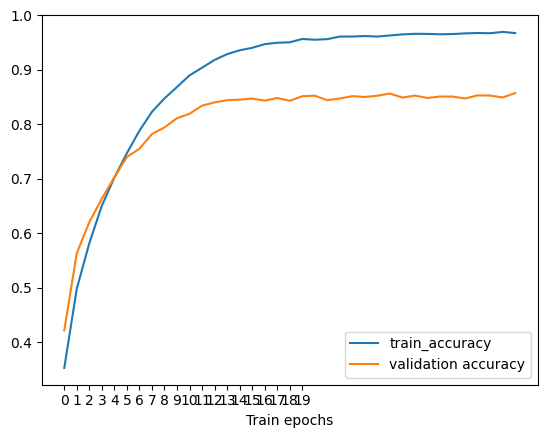

Training accuracy: 0.9677
Validation accuracy: 0.8575

Testing loss: 0.9196
Testing accuracy: 0.8604


In [ ]:
# Functiont to compute training and validation accuracy
def compute_accuracy(model, history, X_train, y_train, X_test, y_test, epochs):
    '''
    Computes the training and validation accuracy after fitting, and evaluates the final testing accuracy.

    Parameters:
    -----------
    model: tf.keras.model
        The CNN model instance created and compiled after fitting.

    history: obj
        The history object returned from model.fit(), containing training metrics.

    X_train: numpy.ndarray
        Training dataset input.

    y_train: numpy.ndarray
        Training dataset labels.

    X_test: numpy.ndarray
        Testing dataset input.

    y_test: numpy.ndarray
        Testing dataset labels.

    epochs: int
        Number of epochs the model was trained for.
    '''

    # Get training and valudation accuracy of digits model
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    # Print last epoch results
    print('Training accuracy: %1.4f' % train_accuracy[-1])
    print('Validation accuracy: %1.4f' % val_accuracy[-1])

    # Evaluate testing results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('\nTesting loss: %1.4f' % test_loss)
    print('Testing accuracy: %1.4f' % test_acc)

# Comptue model accuracies
compute_accuracy(model, history, X_train, y_train , X_test, y_test, 20)


394/394 [==============================] - 1s 2ms/step


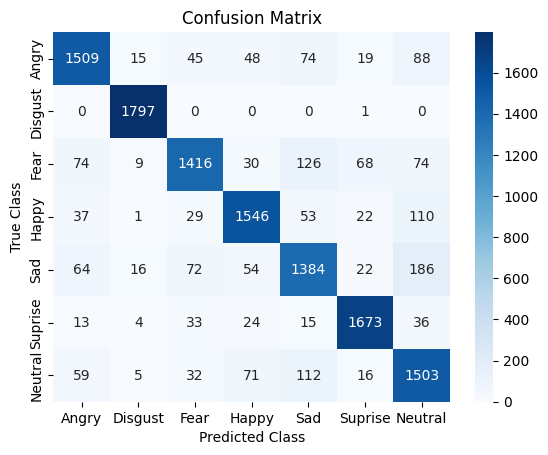

In [ ]:
# Get testing dataset predictions and labels
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds_labels)

# Plot confusion matrix
emotions = ['Angry','Disgust','Fear','Happy','Sad','Suprise','Neutral']
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=emotions,
            yticklabels=emotions)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_3 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 256)       147712    
                                                                 
 batch_normalization_4 (Bat  (None, 21, 21, 256)      

----
### Step 7: Model Live Demo


In [ ]:
live_feed(model) # Type Q to exit out